In [1]:
from scipy.stats import bernoulli
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Use seed for reproducibility
seed = 20160  # seed random number generators for reproducibility

In [8]:
from mlforecast.utils import generate_daily_series

series = generate_daily_series(
    n_series=20,
    max_length=100,
    n_static_features=1,
    static_as_categorical=False,
    with_trend=True
)
series.head()

,ds,y,static_0
unique_id,,,
id_00,2000-01-01,1.751917,72
id_00,2000-01-02,9.196715,72
id_00,2000-01-03,18.577788,72
id_00,2000-01-04,24.520646,72
id_00,2000-01-05,33.418028,72


In [2]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]

/Users/leoncenshuti/opt/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
from mlforecast import Forecast
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

In [10]:
@njit
def rolling_mean_28(x):
    return rolling_mean(x, window_size=28)

fcst = Forecast(
    models=models,
    freq='D',
    lags=[7, 14],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_28]
    },
    date_features=['dayofweek'],
    differences=[1],
)

In [11]:
fcst.fit(series, id_col='index', time_col='ds', target_col='y', static_features=['static_0'])

/Users/leoncenshuti/opt/miniconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Forecast(models=[LGBMRegressor, XGBRegressor, RandomForestRegressor], freq=<Day>, lag_features=['lag-7', 'lag-14', 'expanding_mean_lag-1', 'rolling_mean_28_lag-7'], date_features=['dayofweek'], num_threads=1)

In [12]:
predictions = fcst.predict(14)
predictions

,ds,LGBMRegressor,XGBRegressor,RandomForestRegressor
unique_id,,,,
id_00,2000-04-04,69.082830,67.761337,68.184016
id_00,2000-04-05,75.706024,74.588699,75.470680
id_00,2000-04-06,82.222473,81.058289,82.846249
id_00,2000-04-07,89.577638,88.735947,90.201271
id_00,2000-04-08,44.149095,44.981384,46.096322
...,...,...,...,...
id_19,2000-03-23,30.236012,31.949095,32.656369
id_19,2000-03-24,31.308269,32.765919,33.624488
id_19,2000-03-25,32.788550,33.628864,34.581486


FileNotFoundError: [Errno 2] No such file or directory: 'figs/index.png'

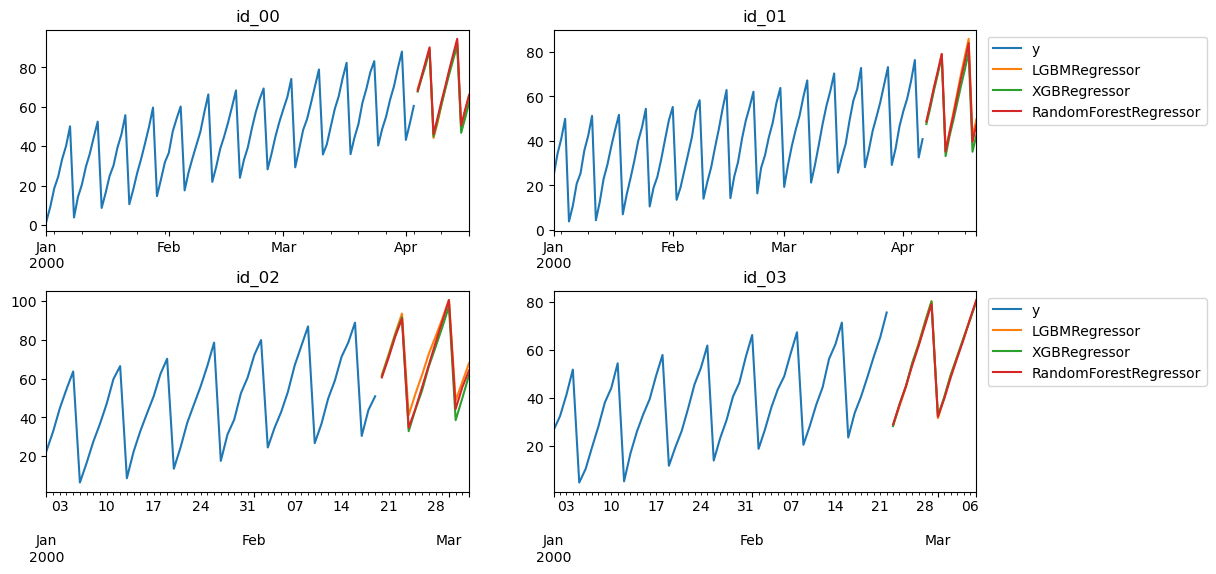

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), gridspec_kw=dict(hspace=0.3))
for i, (cat, axi) in enumerate(zip(series.index.categories, ax.flat)):
    pd.concat([series.loc[cat, ['ds', 'y']], predictions.loc[cat]]).set_index('ds').plot(ax=axi)
    axi.set(title=cat, xlabel=None)
    if i % 2 == 0:
        axi.legend().remove()
    else:
        axi.legend(bbox_to_anchor=(1.01, 1.0))
fig.savefig('figs/index.png', bbox_inches='tight')
plt.close()

In [ ]:
df = pd.read_csv('processed/rwa_sum_features.csv')
df['identifier'] = df['product_id'].astype(str) + '-' + df['name']

df1 = df[['identifier', 'imports']]
df.head()

# chunks = list()
# chunk_size = 
# num_chunks = len(df) // chunk_size + 1

# for i in range(num_chunks):
#     chunks.append(df[i * chunk_size : (i + 1) * chunk_size])

In [ ]:
len(df)

In [ ]:
G = nx.Graph()

G = nx.from_pandas_edgelist(df1, 'identifier', 'imports')

# some properties
# print("node degree clustering")
# for v in nx.nodes(G):
#     print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

# print()
# print("the adjacency list")
# for line in nx.generate_adjlist(G):
#     print(line)
pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos)
plt.show()

In [ ]:
df_ <- pd.read_csv("")
create_using = to_networkx_graph(data)